## ResNet代码实现

### 残差块

In [2]:
import torch
from torch import nn 
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1Conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        
        if use_1x1Conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        # 使用inplace 更省内存
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            # 1 x 1的卷积层，直接作用在X上
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

## 输入和输出形状一致

In [3]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

## 增加输出通道数的同时，减半输出的高和宽(常见的一种设计）

In [4]:
blk = Residual(3, 6, use_1x1Conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## ResNet模型


In [6]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    """
    input_channels: 输入通道
    num_channels: 输出通道数量
    num_residuals: 残差块数量
    """
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1Conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(512, 10))


## 观察一下ResNet不同模块的输入形状是如何变化的


In [7]:
X = torch.rand(size=(1, 1, 224, 224))

for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Sequential output shape: 	 torch.Size([1, 64, 56, 56])
Sequential output shape: 	 torch.Size([1, 64, 56, 56])
Sequential output shape: 	 torch.Size([1, 128, 28, 28])
Sequential output shape: 	 torch.Size([1, 256, 14, 14])
Sequential output shape: 	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape: 	 torch.Size([1, 512, 1, 1])
Flatten output shape: 	 torch.Size([1, 512])
Linear output shape: 	 torch.Size([1, 10])


## 模型训练

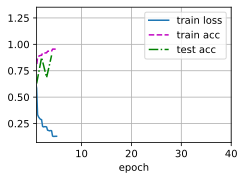

In [ ]:
lr, num_epochs, batch_size = 0.05, 40, 512
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())